In [2]:
import os
os.listdir("../../../results/5 Effective Boxing Combos To Drill In_chunk2")

['alphapose-results.json',
 'curvature_difference_animation.html',
 'curvature_video.mp4',
 'mesh.mp4',
 'mesh.npy',
 'X3D.mp4',
 'X3D.npy']

In [3]:
import numpy as np

sample_data=np.load("../../../results/5 Effective Boxing Combos To Drill In_chunk2/mesh.npy")
sample_data

array([[[  87.316574, -776.78064 , -268.17932 ],
        [  80.89093 , -761.59717 , -266.1903  ],
        [  89.31232 , -763.4291  , -255.15294 ],
        ...,
        [ -54.81541 , -785.03705 , -193.23697 ],
        [ -54.543976, -785.422   , -195.46562 ],
        [ -56.83854 , -782.067   , -196.88486 ]],

       [[  91.20311 , -769.72485 , -268.69656 ],
        [  84.74499 , -754.54956 , -266.65146 ],
        [  92.33314 , -756.827   , -255.13483 ],
        ...,
        [ -55.482063, -778.5321  , -203.59299 ],
        [ -55.060844, -778.8966  , -205.80865 ],
        [ -57.241386, -775.451   , -207.26701 ]],

       [[-139.19699 , -551.3856  ,  -51.697433],
        [-136.22037 , -543.49304 ,  -55.379044],
        [-130.71288 , -544.9776  ,  -43.52089 ],
        ...,
        [-221.7238  , -478.84973 ,  -72.30518 ],
        [-221.95547 , -479.7297  ,  -73.579796],
        [-222.02771 , -477.8921  ,  -76.07828 ]],

       ...,

       [[ 263.26794 , -812.77637 , -137.2471  ],
        [ 2

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class MeshDataset(Dataset):
    def __init__(self, mesh_data, pairs=None):
        """
        Args:
            mesh_data (np.ndarray): (859, 6890, 3) shape의 numpy 배열.
            pairs (list of tuple): 각 tuple이 (i, j) 인덱스 pair. 기본값은 연속된 frame pair.
        """
        self.mesh_data = mesh_data
        if pairs is None:
            # 기본적으로 연속된 frame pair (0,1), (1,2), ..., (857,858)를 사용
            self.pairs = [(i, i+1) for i in range(mesh_data.shape[0]-1)]
        else:
            self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        frame_i = self.mesh_data[i]  # shape: (6890, 3)
        frame_j = self.mesh_data[j]  # shape: (6890, 3)
        # torch.Tensor로 변환 (필요한 경우)
        return torch.from_numpy(frame_i).float(), torch.from_numpy(frame_j).float()

# sample_data 읽기
sample_data = np.load("../../../results/5 Effective Boxing Combos To Drill In_chunk2/mesh.npy")

# Dataset 생성 (원하는 pair 방식을 사용)
dataset = MeshDataset(sample_data)

# DataLoader 생성 (예: batch_size 4, shuffling)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# DataLoader 사용 예제: 한 배치에서 각 pair를 가져오기
for batch in dataloader:
    frames_i, frames_j = batch
    print("Frame_i batch shape:", frames_i.shape)  # (batch_size, 6890, 3)
    print("Frame_j batch shape:", frames_j.shape)  # (batch_size, 6890, 3)
    break


Frame_i batch shape: torch.Size([4, 6890, 3])
Frame_j batch shape: torch.Size([4, 6890, 3])


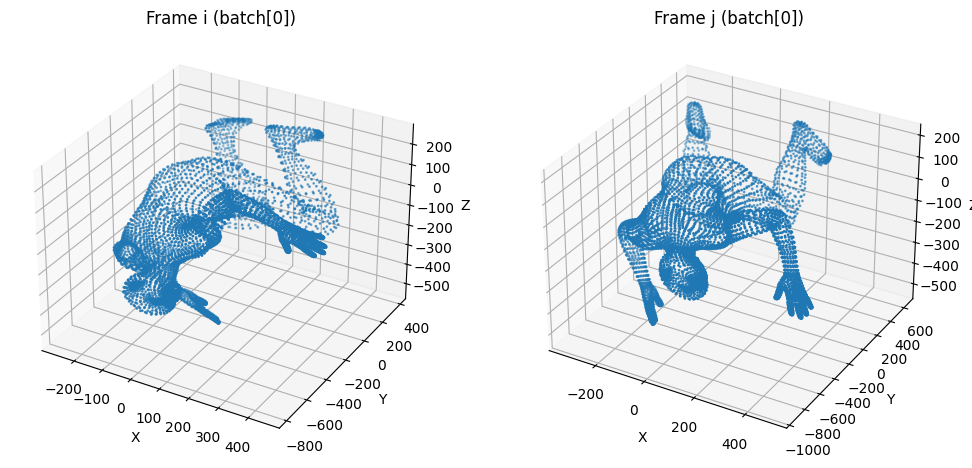

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plot을 위한 import

# DataLoader에서 한 배치 가져오기
batch = next(iter(dataloader))
frames_i, frames_j = batch  # shapes: (batch_size, 6890, 3)

# 첫 번째 배치 예시 선택 (batch index 0)
frame_i_0 = frames_i[0].numpy()  # (6890, 3)
frame_j_0 = frames_j[0].numpy()  # (6890, 3)

# 시각화를 위해 3D scatter plot 생성
fig = plt.figure(figsize=(12, 6))

# 첫 번째 subplot: frame_i의 배치 첫 예시
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(frame_i_0[:, 0], frame_i_0[:, 1], frame_i_0[:, 2], s=1)
ax1.set_title("Frame i (batch[0])")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# 두 번째 subplot: frame_j의 배치 첫 예시
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(frame_j_0[:, 0], frame_j_0[:, 1], frame_j_0[:, 2], s=1)
ax2.set_title("Frame j (batch[0])")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()


In [10]:
os.listdir("../MotionBERT")

['.git',
 '.gitignore',
 'checkpoint',
 'configs',
 'data',
 'data_download.ipynb',
 'docs',
 'filename.png',
 'first_frame.ply',
 'infer_cpu.ipynb',
 'infer_cpu.py',
 'infer_cpu_3d_pose.ipynb',
 'infer_wild.py',
 'infer_wild_mesh.py',
 'joint.npy',
 'lib',
 'LICENSE',
 'mesh.npy',
 'params',
 'README.md',
 'requirements.txt',
 'temp_screenshot.png',
 'tools',
 'train.py',
 'train_action.py',
 'train_action_1shot.py',
 'train_mesh.py']

In [13]:
import torch
import numpy as np
import os.path as osp
from smplx import SMPL as _SMPL
from smplx.utils import ModelOutput, SMPLOutput
from smplx.lbs import vertices2joints


# Map joints to SMPL joints
JOINT_MAP = {
    'OP Nose': 24, 'OP Neck': 12, 'OP RShoulder': 17,
    'OP RElbow': 19, 'OP RWrist': 21, 'OP LShoulder': 16,
    'OP LElbow': 18, 'OP LWrist': 20, 'OP MidHip': 0,
    'OP RHip': 2, 'OP RKnee': 5, 'OP RAnkle': 8,
    'OP LHip': 1, 'OP LKnee': 4, 'OP LAnkle': 7,
    'OP REye': 25, 'OP LEye': 26, 'OP REar': 27,
    'OP LEar': 28, 'OP LBigToe': 29, 'OP LSmallToe': 30,
    'OP LHeel': 31, 'OP RBigToe': 32, 'OP RSmallToe': 33, 'OP RHeel': 34,
    'Right Ankle': 8, 'Right Knee': 5, 'Right Hip': 45,
    'Left Hip': 46, 'Left Knee': 4, 'Left Ankle': 7,
    'Right Wrist': 21, 'Right Elbow': 19, 'Right Shoulder': 17,
    'Left Shoulder': 16, 'Left Elbow': 18, 'Left Wrist': 20,
    'Neck (LSP)': 47, 'Top of Head (LSP)': 48,
    'Pelvis (MPII)': 49, 'Thorax (MPII)': 50,
    'Spine (H36M)': 51, 'Jaw (H36M)': 52,
    'Head (H36M)': 53, 'Nose': 24, 'Left Eye': 26,
    'Right Eye': 25, 'Left Ear': 28, 'Right Ear': 27
}
JOINT_NAMES = [
    'OP Nose', 'OP Neck', 'OP RShoulder',
    'OP RElbow', 'OP RWrist', 'OP LShoulder',
    'OP LElbow', 'OP LWrist', 'OP MidHip',
    'OP RHip', 'OP RKnee', 'OP RAnkle',
    'OP LHip', 'OP LKnee', 'OP LAnkle',
    'OP REye', 'OP LEye', 'OP REar',
    'OP LEar', 'OP LBigToe', 'OP LSmallToe',
    'OP LHeel', 'OP RBigToe', 'OP RSmallToe', 'OP RHeel',
    'Right Ankle', 'Right Knee', 'Right Hip',
    'Left Hip', 'Left Knee', 'Left Ankle',
    'Right Wrist', 'Right Elbow', 'Right Shoulder',
    'Left Shoulder', 'Left Elbow', 'Left Wrist',
    'Neck (LSP)', 'Top of Head (LSP)',
    'Pelvis (MPII)', 'Thorax (MPII)',
    'Spine (H36M)', 'Jaw (H36M)',
    'Head (H36M)', 'Nose', 'Left Eye',
    'Right Eye', 'Left Ear', 'Right Ear'
]

JOINT_IDS = {JOINT_NAMES[i]: i for i in range(len(JOINT_NAMES))}
SMPL_MODEL_DIR = '../MotionBERT/data/mesh'
H36M_TO_J17 = [6, 5, 4, 1, 2, 3, 16, 15, 14, 11, 12, 13, 8, 10, 0, 7, 9]
H36M_TO_J14 = H36M_TO_J17[:14]


class SMPL(_SMPL):
    """ Extension of the official SMPL implementation to support more joints """

    def __init__(self, *args, **kwargs):
        super(SMPL, self).__init__(*args, **kwargs)
        joints = [JOINT_MAP[i] for i in JOINT_NAMES]
        self.smpl_mean_params = osp.join(args[0], 'smpl_mean_params.npz')
        J_regressor_extra = np.load(osp.join(args[0], 'J_regressor_extra.npy'))
        self.register_buffer('J_regressor_extra', torch.tensor(J_regressor_extra, dtype=torch.float32))
        J_regressor_h36m = np.load(osp.join(args[0], 'J_regressor_h36m_correct.npy'))
        self.register_buffer('J_regressor_h36m', torch.tensor(J_regressor_h36m, dtype=torch.float32))
        self.joint_map = torch.tensor(joints, dtype=torch.long)

    def forward(self, *args, **kwargs):
        kwargs['get_skin'] = True
        smpl_output = super(SMPL, self).forward(*args, **kwargs)
        extra_joints = vertices2joints(self.J_regressor_extra, smpl_output.vertices)
        joints = torch.cat([smpl_output.joints, extra_joints], dim=1)
        joints = joints[:, self.joint_map, :]
        output = SMPLOutput(vertices=smpl_output.vertices,
                            global_orient=smpl_output.global_orient,
                            body_pose=smpl_output.body_pose,
                            joints=joints,
                            betas=smpl_output.betas,
                            full_pose=smpl_output.full_pose)
        return output


def get_smpl_faces():
    smpl = SMPL(SMPL_MODEL_DIR, batch_size=1, create_transl=False)
    return smpl.faces

def get_img_from_fig(fig, dpi=120):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi, bbox_inches="tight", pad_inches=0)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    return img

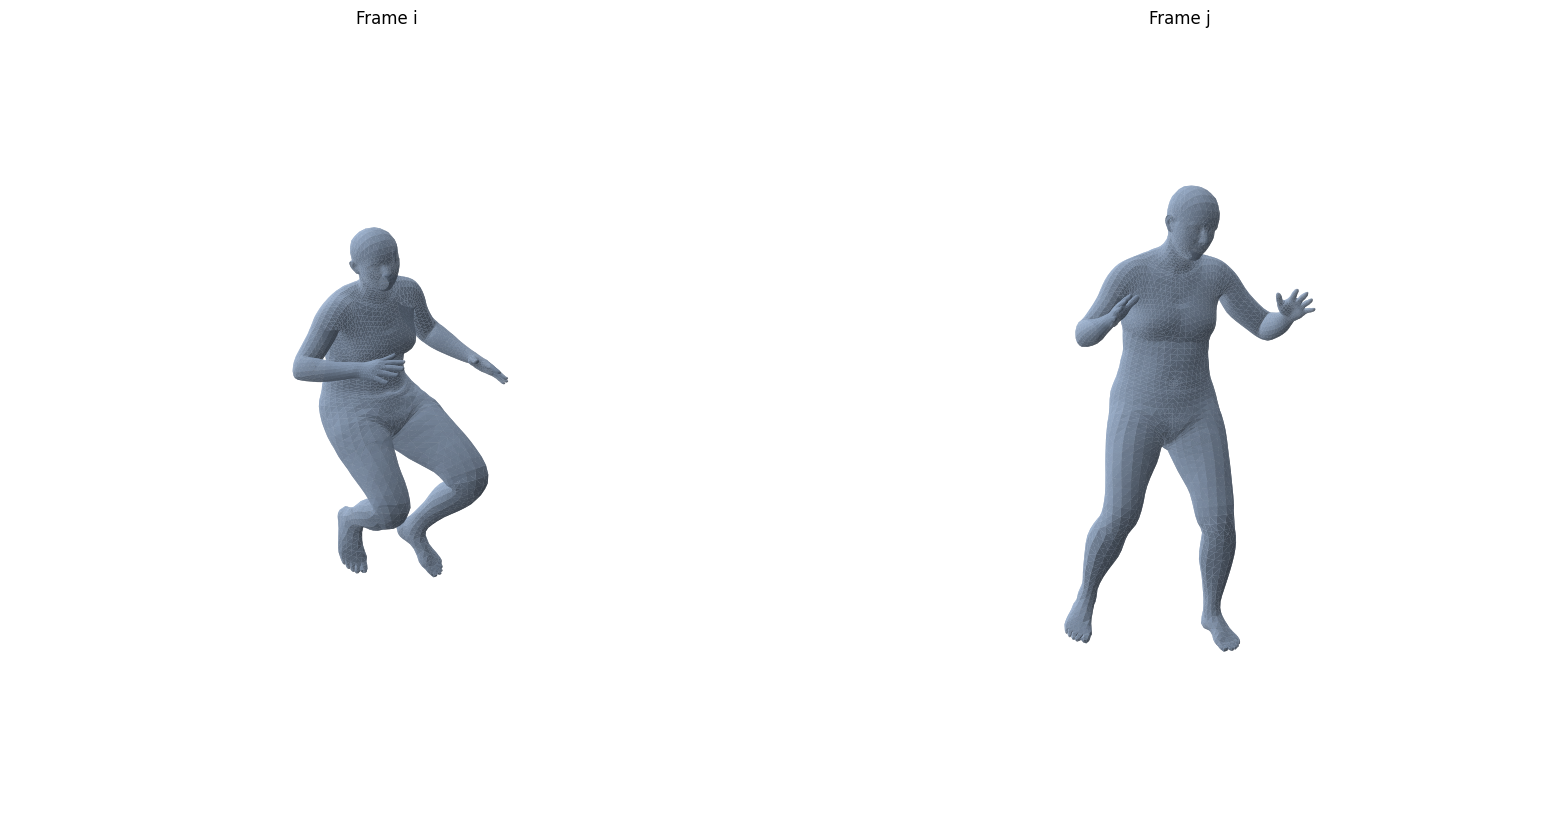

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_mesh_pair(frame_i, frame_j, draw_face=True):
    """
    두 개의 메쉬 프레임을 좌우 subplot으로 시각화하여 plt.show()로 화면에 출력하는 함수.
    
    Args:
        frame_i (np.ndarray): (6890, 3) 크기의 첫 번째 프레임 데이터.
        frame_j (np.ndarray): (6890, 3) 크기의 두 번째 프레임 데이터.
        draw_face (bool): True이면 메쉬 얼굴(면)을 그리며, False이면 산점도(scatter)를 사용.
    """
    # 두 프레임의 좌표 범위를 함께 계산하여 동일한 축 범위를 설정
    combined = np.concatenate((frame_i, frame_j), axis=0)
    X, Y, Z = combined[:, 0], combined[:, 1], combined[:, 2]
    max_range = np.array([X.max() - X.min(), Y.max() - Y.min(), Z.max() - Z.min()]).max() / 2.0
    mid_x = (X.max() + X.min()) * 0.5
    mid_y = (Y.max() + Y.min()) * 0.5
    mid_z = (Z.max() + Z.min()) * 0.5

    # Figure 생성 (좌우 subplot)
    fig = plt.figure(figsize=(16, 8))
    
    # 왼쪽 subplot: frame_i 시각화
    ax1 = fig.add_subplot(121, projection="3d", proj_type='ortho')
    ax1.set_xlim(mid_x - max_range, mid_x + max_range)
    ax1.set_ylim(mid_y - max_range, mid_y + max_range)
    ax1.set_zlim(mid_z - max_range, mid_z + max_range)
    ax1.view_init(elev=-90, azim=-90)
    ax1.axis('off')
    
    if draw_face:
        # get_smpl_faces() 함수가 외부에 정의되어 있어야 합니다.
        smpl_faces = get_smpl_faces()
        ax1.plot_trisurf(frame_i[:, 0], frame_i[:, 1],
                         triangles=smpl_faces, Z=frame_i[:, 2],
                         color=(166/255.0, 188/255.0, 218/255.0, 0.9))
    else:
        ax1.scatter(frame_i[:, 0], frame_i[:, 1], frame_i[:, 2],
                    s=3, c='w', edgecolors='grey')
    ax1.set_title("Frame i", pad=20)
    
    # 오른쪽 subplot: frame_j 시각화
    ax2 = fig.add_subplot(122, projection="3d", proj_type='ortho')
    ax2.set_xlim(mid_x - max_range, mid_x + max_range)
    ax2.set_ylim(mid_y - max_range, mid_y + max_range)
    ax2.set_zlim(mid_z - max_range, mid_z + max_range)
    ax2.view_init(elev=-90, azim=-90)
    ax2.axis('off')
    
    if draw_face:
        smpl_faces = get_smpl_faces()
        ax2.plot_trisurf(frame_j[:, 0], frame_j[:, 1],
                         triangles=smpl_faces, Z=frame_j[:, 2],
                         color=(166/255.0, 188/255.0, 218/255.0, 0.9))
    else:
        ax2.scatter(frame_j[:, 0], frame_j[:, 1], frame_j[:, 2],
                    s=3, c='w', edgecolors='grey')
    ax2.set_title("Frame j", pad=20)
    
    plt.tight_layout()
    plt.show()

# 예시 사용:
# 예를 들어, DataLoader에서 가져온 첫 번째 배치의 frame_i와 frame_j가 torch.Tensor라면:
frame_i_np = frames_i[0].numpy()
frame_j_np = frames_j[0].numpy()
visualize_mesh_pair(frame_i_np, frame_j_np, draw_face=True)


In [23]:
dataset = MeshDataset(sample_data)

# DataLoader 생성 (예: batch_size 4, shuffling)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# DataLoader 사용 예제: 한 배치에서 각 pair를 가져오기
for batch in dataloader:
    frames_i, frames_j = batch
    print("Frame_i batch shape:", frames_i.shape)  # (batch_size, 6890, 3)
    print("Frame_j batch shape:", frames_j.shape)  # (batch_size, 6890, 3)
    break


Frame_i batch shape: torch.Size([4, 6890, 3])
Frame_j batch shape: torch.Size([4, 6890, 3])


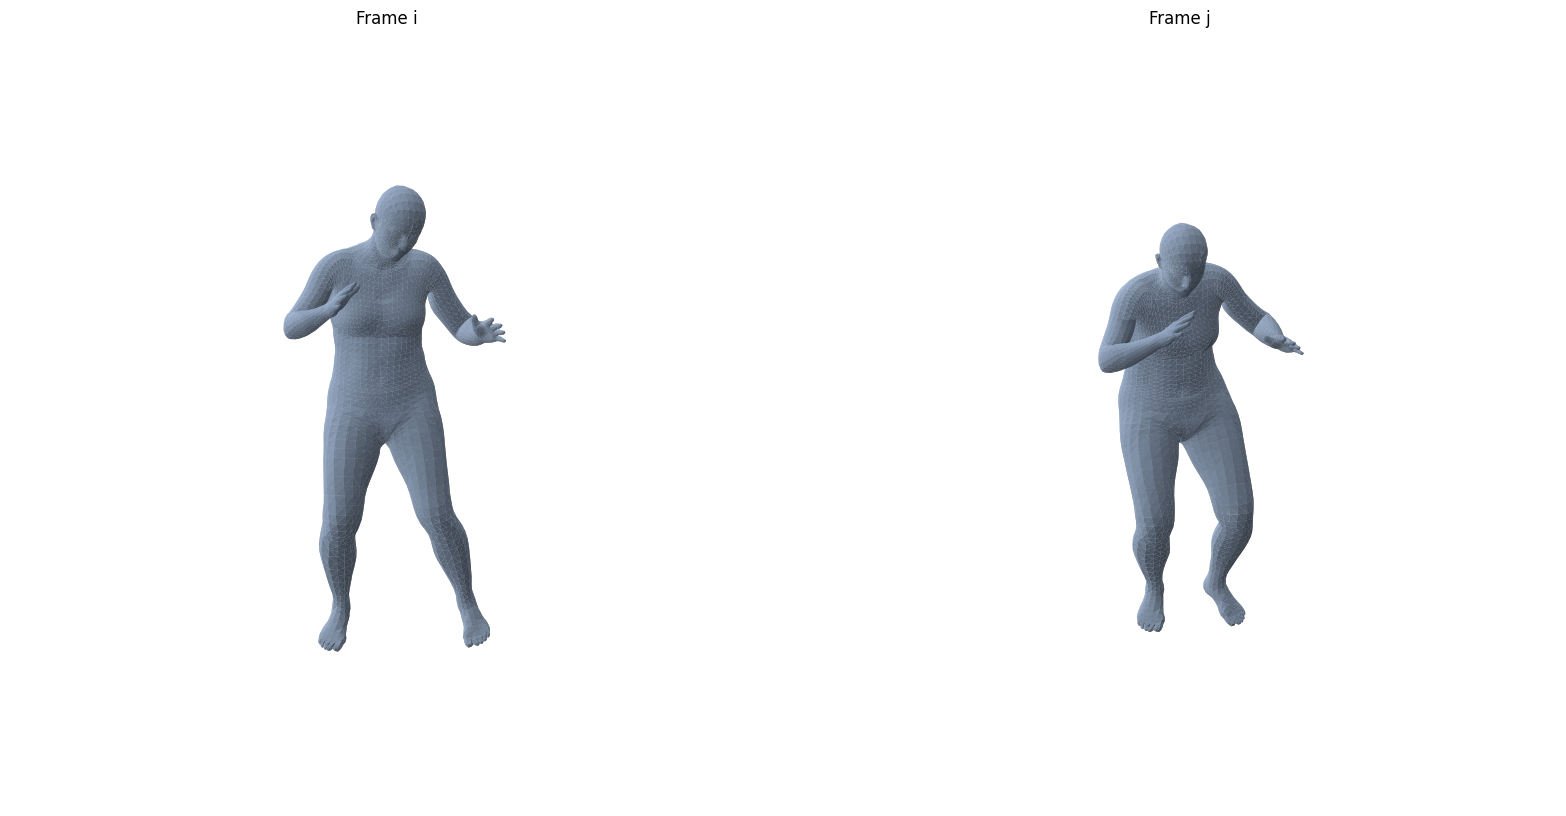

In [24]:
frame_i_np = frames_i[0].numpy()
frame_j_np = frames_j[0].numpy()
visualize_mesh_pair(frame_i_np, frame_j_np, draw_face=True)
